# \[STBDA\] 10wk: softmax function, 평가지표, flatten layer

김보람  
2023-07-12

> 해당 강의노트는 전북대학교 최규빈교수님
> [STBDA2022](https://guebin.github.io/STBDA2022/) 자료임

## imports

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.experimental.numpy as tnp

In [2]:
tnp.experimental_enable_numpy_behavior()

In [3]:
tf.config.experimental.list_physical_devices()

In [5]:
import graphviz
def gv(s): return graphviz.Source('digraph G{ rankdir="LR"'+ s + ';}')

## softmax function

### 로지스틱 모형 (1): 활성화함수로 sigmoid 선택

`-` 기본버전은 아래와 같다

$$y_i \approx \text{sigmoid}(b + w_1 x_{1,i} + \dots + w_{784}x_{784,i})= \frac{\exp(b + w_1 x_{1,i} + \dots + w_{784}x_{784,i})}{1+\exp(b + w_1 x_{1,i} + \dots + w_{784}x_{784,i})}$$

`-` 벡터버전은 아래와 같다.

$${\boldsymbol y} \approx \text{sigmoid}({\bf X}{\bf W} + b) = \frac{\exp({\bf XW} +b)}{1+\exp({\bf XW} +b)}$$

`-` 벡터버전에 익숙해지도록 하자. 벡터버전에 사용된 차원 및 연산을
정리하면 아래와 같다.

-   ${\bf X}$: (n,784) matrix

-   ${\boldsymbol y}$: (n,1) matrix

-   ${\bf W}$: (784,1) matrix

-   $b$: (1,1) matrix

-   `+`, `exp` 는 브로드캐스팅

### 로지스틱 모형 (2): 활성화함수로 softmax 선택

`-` $y_i=0 \text{ or } 1$ 대신에
$\boldsymbol{y}_i=[y_{i1},y_{i2}]= [1,0] \text { or } [0,1]$와 같이
코딩하면 어떠할까? (즉 원핫인코딩을 한다면?)

`-` 활성화 함수를 취하기 전의 버전은 아래와 같이 볼 수 있다.

$$[{\boldsymbol y}_1 ~ {\boldsymbol y}_2] \propto  [ {\bf X}{\bf W}_1  ~ {\bf X}{\bf W}_2] + [b_1 ~ b_2]= {\bf X} [{\bf W}_1 {\bf W}_2] + [b_1 ~ b_2]= {\bf X}{\bf W} + {\boldsymbol b}$$

여기에서 매트릭스 및 연산의 차원을 정리하면 아래와 같다.

-   ${\bf X}$: (n,784) matrix

-   ${\boldsymbol y}_1,{\boldsymbol y}_2$: (n,1) matrix

-   ${\boldsymbol y}:=[{\boldsymbol y}_1~ {\boldsymbol y}_2]$: (n,2)
    matrix

-   ${\bf W}_1$, ${\bf W}_2$: (784,1) matrix

-   ${\bf W}:=[{\bf W}_1~ {\bf W}_2]$: (784,2) matrix

-   $b_1,b_2$: (1,1) matrix

-   \$:= \[b_1 ~b_2\] \$: (1,2) matrix

-   `+` 는 브로드캐스팅

`-` 즉 로지스틱 모형 (1)의 형태를 겹쳐놓은 형태로 해석할 수 있음. 따라서
${\bf X} {\bf W}_1 + b_1$와 ${\bf X} {\bf W}_2 + b_2$의 row값이 클수록
${\boldsymbol y}_1$와 ${\boldsymbol y}_2$의 row값이 1이어야 함

-   ${\boldsymbol y}_1 \propto {\bf X} {\bf W}_1 + b_1$ $\to$
    ${\bf X} {\bf W}_1 + b_1$의 row값이 클수록 $\boldsymbol{y}_1$의 row
    값이 1이라면 모형계수를 잘 추정한것
-   ${\boldsymbol y}_2 \propto {\bf X} {\bf W}_2 + b_2$ $\to$
    ${\bf X} {\bf W}_2 + b_2$의 row값이 클수록 $\boldsymbol{y}_2$의 row
    값을 1이라면 모형계수를 잘 추정한것

`-` (문제) ${\bf X}{\bf W}_1 +b_1$의 값이 500, ${\bf X}{\bf W}_2 +b_2$의
값이 200 인 row가 있다고 하자. 대응하는
$\boldsymbol{y}_1, \boldsymbol{y}_2$의 row값은 얼마로 적합되어야 하는가?

1.  $[0,0]$

2.  $[0,1]$

3.  $[1,0]$ \<– 이게 답이다!

4.  $[1,1]$

> note: 둘다 0 혹은 둘다 1로 적합할수는 없으니까 (1), (4)는 제외한다.
> ${\bf X}{\bf W}_1 +b_1$의 값이 ${\bf X}{\bf W}_2 +b_2$의 값보다 크므로
> (3)번이 합리적임

`-` **목표:** 위와 같은 문제의 답을 유도해주는 활성화함수를 설계하자. 즉
합리적인 $\hat{\boldsymbol{y}}_1,\hat{\boldsymbol{y}}_2$를 구해주는
활성화 함수를 설계해보자. 이를 위해서는 아래의 사항들이 충족되어야 한다.

1.  $\hat{\boldsymbol{y}}_1$, $\hat{\boldsymbol{y}}_2$의 각 원소는 0보다
    크고 1보다 작아야 한다. (확률을 의미해야 하니까)

2.  $\hat{\boldsymbol{y}}_1+\hat{\boldsymbol{y}}_2={\bf 1}$ 이어야 한다.
    (확률의 총합은 1이니까!)

3.  $\hat{\boldsymbol{y}}_1$와 $\hat{\boldsymbol{y}}_2$를 각각
    따로해석하면 로지스틱처럼 되면 좋겠다.

`-` 아래와 같은 활성화 함수를 도입하면 어떨까?

$$\hat{\boldsymbol{y}}=[\hat{\boldsymbol y}_1 ~ \hat{\boldsymbol y}_2] =  \big[ \frac{\exp({\bf X}\hat{\bf W}_1+\hat{b}_1)}{\exp({\bf X}\hat{\bf W}_1+\hat{b}_1)+\exp({\bf X}\hat{\bf W}_2+\hat{b}_2)}  ~~ \frac{\exp({\bf X}\hat{\bf W}_2+\hat{b}_2)}{\exp({\bf X}\hat{\bf W}_1+\hat{b}_1)+\exp({\bf X}\hat{\bf W}_2+\hat{b}_2)}  \big]$$

`-` (1),(2)는 만족하는 듯 하다. (3)은 바로 이해되지는 않는다

1.  $\hat{\boldsymbol{y}}_1$, $\hat{\boldsymbol{y}}_2$의 각 원소는 0보다
    크고 1보다 작아야 한다. –\> OK!

2.  $\hat{\boldsymbol{y}}_1+\hat{\boldsymbol{y}}_2={\bf 1}$ 이어야 한다.
    –\> OK!

3.  $\hat{\boldsymbol{y}}_1$와 $\hat{\boldsymbol{y}}_2$를 각각
    따로해석하면 로지스틱처럼 되면 좋겠다. –\> ???

`-` 그런데 조금 따져보면 (3)도 만족된다는 것을 알 수 있다. (sigmoid,
softmax Section 참고)

`-` 위와 같은 함수를 softmax라고 하자. 즉 아래와 같이 정의하자.

$$
\hat{\boldsymbol y} = \text{softmax}({\bf X}\hat{\bf W} + {\boldsymbol b})
= \big[ \frac{\exp({\bf X}\hat{\bf W}_1+\hat{b}_1)}{\exp({\bf X}\hat{\bf W}_1+\hat{b}_1)+\exp({\bf X}\hat{\bf W}_2+\hat{b}_2)}  ~~ \frac{\exp({\bf X}\hat{\bf W}_2+\hat{b}_2)}{\exp({\bf X}\hat{\bf W}_1+\hat{b}_1)+\exp({\bf X}\hat{\bf W}_2+\hat{b}_2)}  \big]
$$

### sigmoid, softmax

#### **softmax는 sigmoid의 확장형**

`-` 아래의 수식을 관찰하자.
$$\frac{\exp(\beta_0+\beta_1 x_i)}{1+\exp(\beta_0+\beta_1x_i)}=\frac{\exp(\beta_0+\beta_1 x_i)}{e^0+\exp(\beta_0+\beta_1x_i)}$$

`-` 1을 $e^0$로 해석하면 모형2의 해석을 아래와 같이 모형1의 해석으로
적용할수 있다. - 모형2: ${\bf X}\hat{\bf W}_1 +\hat{b}_1$ 와
${\bf X}\hat{\bf W}_2 +\hat{b}_2$ 의 크기를 비교하고 확률 결정 - 모형1:
${\bf X}\hat{\bf W} +\hat{b}$ 와 $0$의 크기를 비교하고 확률 결정 =
${\bf X}\hat{\bf W} +\hat{b}$의 row값이 양수이면 1로 예측하고 음수이면
0으로 예측

`-` 이항분포를 차원이 2인 다항분포로 해석가능한 것처럼 sigmoid는 차원이
2인 softmax로 해석가능하다. 즉 다항분포가 이항분포의 확장형으로
해석가능한 것처럼 softmax도 sigmoid의 확장형으로 해석가능하다.

#### **클래스의 수가 2인 경우 softmax vs sigmoid**

`-` 언뜻 생각하면 클래스가 2인 경우에도 sigmoid 대신 softmax로
활성화함수를 이용해도 될 듯 하다. 즉 $y=0 \text{ or } 1$와 같이 정리하지
않고 $y=[0,1] \text{ or } [1,0]$ 와 같이 정리해도 무방할 듯 하다.

`-` 하지만 sigmoid가 좀 더 좋은 선택이다. 즉 $y= 0 \text{ or } 1$로
데이터를 정리하는 것이 더 좋은 선택이다. 왜냐하면 sigmoid는 softmax와
비교하여 파라메터의 수가 적지만 표현력은 동등하기 때문이다.

`-` 표현력이 동등한 이유? 아래 수식을 관찰하자.

$$\big(\frac{e^{300}}{e^{300}+e^{500}},\frac{e^{500}}{e^{300}+e^{500}}\big) =\big( \frac{e^{0}}{e^{0}+e^{200}}, \frac{e^{200}}{e^{0}+e^{200}}\big)$$

-   $\big(\frac{e^{300}}{e^{300}+e^{500}},\frac{e^{500}}{e^{300}+e^{500}}\big)$를
    표현하기 위해서 300, 500 이라는 2개의 숫자가 필요한것이 아니고
    따지고보면 200이라는 하나의 숫자만 필요하다.
-   $(\hat{\boldsymbol{y}}_1,\hat{\boldsymbol{y}}_2)$의 표현에서도
    ${\bf X}\hat{\bf W}_1 +\hat{b}_1$ 와
    ${\bf X}\hat{\bf W}_2 +\hat{b}_2$ 라는 숫자 각각이 필요한 것이
    아니고
    $({\bf X}\hat{\bf W}_1 +\hat{b}_1)-({\bf X}\hat{\bf W}_2 +\hat{b}_2)$의
    값만 알면 된다.

`-` 클래스의 수가 2개일 경우는 softmax가 sigmoid에 비하여 장점이 없다.
하지만 softmax는 클래스의 수가 3개 이상일 경우로 쉽게 확장할 수 있다는
점에서 매력적인 활성화 함수이다.

### 분류할 클래스가 3개 이상일 경우 신경망 모형의 설계

`-` y의 모양: \[0 1 0 0 0 0 0 0 0 0\]

`-` 활성화함수의 선택: softmax

`-` 손실함수의 선택: cross entropy

### Fashion_MNIST 여러클래스의 분류 (softmax의 실습)

`-` 데이터정리

In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [7]:
X= x_train.reshape(-1,784)
y= tf.keras.utils.to_categorical(y_train)
XX = x_test.reshape(-1,784)
yy = tf.keras.utils.to_categorical(y_test)

`-` 시도1: 간단한 신경망

In [8]:
#collapse
gv('''
splines=line
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "x1"
    "x2"
    ".."
    "x784"
    label = "Layer 0"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "x1" -> "node1"
    "x2" -> "node1"
    ".." -> "node1"

    "x784" -> "node1"
    "x1" -> "node2"
    "x2" -> "node2"
    ".." -> "node2"
    "x784" -> "node2"

    "x1" -> "..."
    "x2" -> "..."
    ".." -> "..."
    "x784" -> "..."

    "x1" -> "node30"
    "x2" -> "node30"
    ".." -> "node30"
    "x784" -> "node30"


    label = "Layer 1: relu"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;

    "node1" -> "y10"
    "node2" -> "y10"
    "..." -> "y10"
    "node30" -> "y10"

    "node1" -> "y1"
    "node2" -> "y1"
    "..." -> "y1"
    "node30" -> "y1"

    "node1" -> "."
    "node2" -> "."
    "..." -> "."
    "node30" -> "."

    label = "Layer 2: softmax"
}
''')

In [9]:
net = tf.keras.Sequential()
net.add(tf.keras.layers.Dense(30,activation = 'relu'))
net.add(tf.keras.layers.Dense(10,activation = 'softmax'))
net.compile(loss=tf.losses.categorical_crossentropy, optimizer='adam',metrics=['accuracy'])
net.fit(X,y,epochs=5)

Epoch 1/5
1875/1875 [==============================] - 1s 515us/step - loss: 1.9693 - accuracy: 0.4597
Epoch 2/5
1875/1875 [==============================] - 1s 511us/step - loss: 1.0388 - accuracy: 0.5878
Epoch 3/5
1875/1875 [==============================] - 1s 511us/step - loss: 0.8715 - accuracy: 0.6531
Epoch 4/5
1875/1875 [==============================] - 1s 515us/step - loss: 0.7917 - accuracy: 0.6804
Epoch 5/5
1875/1875 [==============================] - 1s 508us/step - loss: 0.7568 - accuracy: 0.6905

In [10]:
net.evaluate(XX,yy)

313/313 [==============================] - 0s 394us/step - loss: 0.7765 - accuracy: 0.6829

In [11]:
net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                23550     
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
Total params: 23,860
Trainable params: 23,860
Non-trainable params: 0
_________________________________________________________________

`-` 시도2: 더 깊은 신경망

In [12]:
#collapse
gv('''
splines=line
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "x1"
    "x2"
    ".."
    "x784"
    label = "Layer 0"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "x1" -> "node1"
    "x2" -> "node1"
    ".." -> "node1"

    "x784" -> "node1"
    "x1" -> "node2"
    "x2" -> "node2"
    ".." -> "node2"
    "x784" -> "node2"

    "x1" -> "..."
    "x2" -> "..."
    ".." -> "..."
    "x784" -> "..."

    "x1" -> "node500"
    "x2" -> "node500"
    ".." -> "node500"
    "x784" -> "node500"


    label = "Layer 1: relu"
}

subgraph cluster_3{
    style=filled;
    color=lightgrey;

    "node1" -> "node1(2)"
    "node2" -> "node1(2)"
    "..." -> "node1(2)"
    "node500" -> "node1(2)"

    "node1" -> "node2(2)"
    "node2" -> "node2(2)"
    "..." -> "node2(2)"
    "node500" -> "node2(2)"

    "node1" -> "...."
    "node2" -> "...."
    "..." -> "...."
    "node500" -> "...."

    "node1" -> "node500(2)"
    "node2" -> "node500(2)"
    "..." -> "node500(2)"
    "node500" -> "node500(2)"


    label = "Layer 2: relu"
}

subgraph cluster_4{
    style=filled;
    color=lightgrey;

    "node1(2)" -> "y10"
    "node2(2)" -> "y10"
    "...." -> "y10"
    "node500(2)" -> "y10"

    "node1(2)" -> "y1"
    "node2(2)" -> "y1"
    "...." -> "y1"
    "node500(2)" -> "y1"

    "node1(2)" -> "."
    "node2(2)" -> "."
    "...." -> "."
    "node500(2)" -> "."

    label = "Layer 3: softmax"
}
''')

In [13]:
net = tf.keras.Sequential()
net.add(tf.keras.layers.Dense(500,activation = 'relu'))
net.add(tf.keras.layers.Dense(500,activation = 'relu'))
net.add(tf.keras.layers.Dense(10,activation = 'softmax'))
net.compile(loss=tf.losses.categorical_crossentropy, optimizer='adam',metrics=['accuracy'])
net.fit(X,y,epochs=5)

Epoch 1/5
1875/1875 [==============================] - 3s 1ms/step - loss: 2.1970 - accuracy: 0.7556
Epoch 2/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.6298 - accuracy: 0.7915
Epoch 3/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.5368 - accuracy: 0.8200
Epoch 4/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4760 - accuracy: 0.8366
Epoch 5/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4351 - accuracy: 0.8476

In [14]:
net.evaluate(XX,yy)

313/313 [==============================] - 0s 567us/step - loss: 0.5347 - accuracy: 0.8281

In [15]:
net.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 500)               392500    
                                                                 
 dense_3 (Dense)             (None, 500)               250500    
                                                                 
 dense_4 (Dense)             (None, 10)                5010      
                                                                 
Total params: 648,010
Trainable params: 648,010
Non-trainable params: 0
_________________________________________________________________

## 평가지표

### 다양한 평가지표들

`-` 의문: 왜 다양한 평가지표가 필요한가? (accuray면 끝나는거 아닌가? 더
이상 뭐가 필요해?)

`-` 여러가지 평가지표들:
https://en.wikipedia.org/wiki/Positive_and_negative_predictive_values -
이걸 다 암기하는건 불가능함. - 몇 개만 뽑아서 암기하고 왜 쓰는지만
생각해보고 넘어가자!

### confusion matrix의 이해

`-` 표1

|              | 퇴사(예측) | 안나감(예측) |
|:------------:|:----------:|:------------:|
|  퇴사(실제)  |     TP     |      FN      |
| 안나감(실제) |     FP     |      TN      |

`-` 표2 (책에없음)

|              |    퇴사(예측)    |  안나감(예측)   |
|:------------:|:----------------:|:---------------:|
|  퇴사(실제)  | \$(y,)= \$ (O,O) | \$(y,)= \$(O,X) |
| 안나감(실제) | \$(y,)= \$(X,O)  | \$(y,)= \$(X,X) |

`-` 표3 (책에없음)

|              |  퇴사(예측)  | 안나감(예측) |
|:------------:|:------------:|:------------:|
|  퇴사(실제)  | TP, $\# O/O$ | FN, $\#O/X$  |
| 안나감(실제) | FP, $\#X/O$  | TN, $\#X/X$  |

-   암기법, (1) 두번째 글자를 그대로 쓴다 (2) 첫글자가 T이면 분류를
    제대로한것, 첫글자가 F이면 분류를 잘못한것

`-` 표4 (위키등에 있음)

|              |                              퇴사(예측)                               | 안나감(예측) |                                                                                     |
|:----------------:|:----------------:|:----------------:|:----------------:|
|  퇴사(실제)  |                             TP, $\# O/O$                              | FN, $\# O/X$ | Sensitivity(민감도)=Recall(재현율)=$\frac{TP}{TP+FN}$=$\frac{\#O/O}{\# O/O+ \#O/X}$ |
| 안나감(실제) |                             FP, $\# X/O$                              | TN, $\# X/X$ |                                                                                     |
|              | Precision(프리시즌)=$\frac{TP}{TP+FP}$=$\frac{\# O/O}{\# O/O+\# X/O}$ |              |        Accuracy(애큐러시)=$\frac{TP+TN}{total}$=$\frac{\#O/O+\# X/X}{total}$        |

### 상황극

`-` 최규빈은 입사하여 “퇴사자 예측시스템”의 개발에 들어갔다.

`-` 자료의 특성상 대부분의 사람이 퇴사하지 않고 회사에 잘 다닌다. 즉
1000명이 있으면 10명정도 퇴사한다.

### Accuracy

`-` 정의:
Accuracy(애큐러시)=$\frac{TP+TN}{total}$=$\frac{\#O/O+ \#X/X}{total}$ -
한국말로는 정확도, 정분류율이라고 한다. - 한국말이 헷갈리므로 그냥
영어를 외우는게 좋다. (어차피 Keras에서 옵션도 영어로 넣음)

`-` (상확극 시점1) 왜 애큐러시는 불충분한가? - 회사: 퇴사자예측프로그램
개발해 - 최규빈: 귀찮은데 다 안나간다고 하자! -\> 99퍼의 accuracy

> 모델에 사용한 파라메터 = 0. 그런데 애큐러시 = 99! 이거 엄청 좋은
> 모형이다?

### Sensitivity(민감도), Recall(재현율), True Positive Rate(TPR)

`-` 정의:
Sensitivity(민감도)=Recall(재현율)=$\frac{TP}{TP+FN}$=$\frac{\# O/O}{\# O/O+\# O/X}$ -
분모: 실제 O인 관측치 수 - 분자: 실제 O를 O라고 예측한 관측치 수 - 뜻:
실제 O를 O라고 예측한 비율

`-` (상황극 시점2) recall을 봐야하는 이유 - 인사팀: 실제 퇴사자를
퇴사자로 예측해야 의미가 있음! 우리는 퇴사할것 같은 10명을 찍어달란
의미였어요! (그래야 면담을 하든 할거아냐!) - 최규빈: 가볍고(=파라메터
적고) 잘 맞추는 모형 만들어 달라면서요?

-   인사팀: (고민중..) 사실 생각해보니까 이 경우는 애큐러시는 의미가
    없네. 실제 나간 사람 중 최규빈이 나간다고 한 사람이 몇인지 카운트
    하는게 더 의미가 있겠다. 우리는 앞으로 리컬(혹은 민감도)를 보겠다!

> 예시1: 실제로 퇴사한 10명중 최규빈이 나간다고 찍은 사람이 5명이면
> 리컬이 50%

> 예시2: 최규빈이 아무도 나가지 않는다고 예측해버린다? 실제 10명중에서
> 최규빈이 나간다고 적중시킨사람은 0명이므로 이 경우 리컬은 0%

-   결론: 우리가 필요한건 recall이니까 앞으로 recall을 가져와!
    accuracy는 큰 의미없어. (그래도 명색이 모델인데 accuracy가 90은 되면
    좋겠다)

### Precision

`-` 정의:
Precision(프리시즌)=$\frac{TP}{TP+FP}$=$\frac{\# O/O}{\# O/O+\# X/O}$ -
분모: O라고 예측한 관측치 - 분자: O라고 예측한 관측치중 진짜 O인
관측치 - 뜻: O라고 예측한 관측치중 진짜 O인 비율

`-` (상황극 시점3) recall 만으로 불충분한 이유

-   최규빈: 에휴.. 귀찮은데 그냥 좀만 수틀리면 다 나갈것 같다고
    해야겠다. -\> 한 100명 나간다고 했음 -\> 실제로 최규빈이 찍은
    100명중에 10명이 다 나감!

> 이 경우 애큐러시는 91%, 리컬은 100% (퇴사자 10명을 일단은 다
> 맞췄으므로).

-   인사팀: (화가 많이 남) 멀쩡한 사람까지 다 퇴사할 것 같다고 하면
    어떡해요? 최규빈 연구원이 나간다고 한 100명중에 실제로 10명만
    나갔어요.

-   인사팀: 마치 총으로 과녁중앙에 맞춰 달라고 했더니 기관총을 가져와서
    한번 긁은것이랑 뭐가 달라요? 맞추는게 문제가 아니고 precision이 너무
    낮아요.

-   최규빈: accuracy 90% 이상, recall은 높을수록 좋다는게 주문
    아니었나요?

-   인사팀: (고민중..) 앞으로는 recall과 함께 precision도 같이
    제출하세요. precision은 당신이 나간다고 한 사람중에 실제 나간사람의
    비율을 의미해요. 이 경우는 $\frac{10}{100}$이니까 precision이
    10%입니다. (속마음: recall 올리겠다고 무작정 너무 많이 예측하지 말란
    말이야!)

### F1 score

`-` 정의: recall과 precision의 조화평균

`-` (상황극 시점4) recall, precision을 모두 고려

-   최규빈: recall/precision을 같이 내는건 좋은데요, 둘은 trade off의
    관계에 있습니다. 물론 둘다 올리는 모형이 있다면 좋지만 그게 쉽지는
    않아요. 보통은 precision을 올리려면 recall이 희생되는 면이 있고요,
    recall을 올리려고 하면 precision이 다소 떨어집니다.

-   최규빈: 평가기준이 애매하다는 의미입니다. 모형1,2가 있는데 모형1은
    모형2보다 precision이 약간 좋고 대신 recall이 떨어진다면 모형1이
    좋은것입니까? 아니면 모형2가 좋은것입니까?

-   인사팀: 그렇다면 둘을 평균내서 F1score를 계산해서 제출해주세요.

### Specificity(특이도), False Positive Rate(FPR)

`-` 정의:

1.  Specificity(특이도)=$\frac{TN}{FP+TN}$=$\frac{\# X/X}{\# X/O+\# X/X}$

2.  False Positive Rate (FPR) = 1-Specificity(특이도) =
    $\frac{FP}{FP+TN}$=$\frac{\# X/O}{\# X/O+\# X/X}$

`-` 의미: **FPR = 오해해서 미안해, recall(=TPR)을 올리려고 보니 어쩔 수
없었어 ㅠㅠ** - specificity는 안나간 사람을 안나갔다고 찾아낸 비율인데
별로 안중요하다. - FPR은 recall을 올리기 위해서 “실제로는 회사 잘 다니고
있는 사람 중 최규빈이 나갈것 같다고 찍은 사람들” 의 비율이다.

> 즉 생사람잡은 비율.. 오해해서 미안한 사람의 비율..

### ROC curve

`-` 정의: $x$축=FPR, $y$축=TPR 을 그린 커브

`-` 의미: - 결국 “오해해서 미안해 vs recall”을 그린 곡선이
ROC커브이다. - 생각해보면 오해하는 사람이 많을수록 당연히 recall은
올라간다. 따라서 우상향하는 곡선이다. - 오해한 사람이 매우 적은데
recall이 우수하면 매우 좋은 모형이다. 그래서 초반부터 ROC값이 급격하게
올라가면 좋은 모형이다.

### Fashion MNIST 다양한 평가지표활용

`-` data

In [16]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [18]:
x_train.shape

-   이미지는 원래 가로픽셀 세로픽셀 3 이어야 한다. (색을 표현하는
    basis는 빨,녹,파)

`-` 따라서 이미지의 차원이 단지 (28,28)이라는 것은 흑백이미지라는
뜻이다.

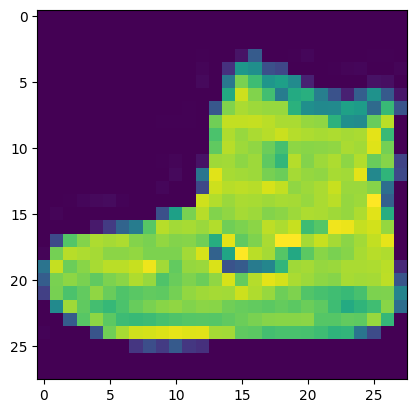

In [19]:
plt.imshow(x_train[0]) 

-   아닌데요?! 칼라인데요?! -\> 흑백이다. 그냥 밝을수록 노란색,
    어두울수록 남색으로 표현한것 뿐임 (colormap이 viridis일 뿐임)

In [17]:
X= x_train.reshape(-1,784)
y= tf.keras.utils.to_categorical(y_train)
XX = x_test.reshape(-1,784)
yy = tf.keras.utils.to_categorical(y_test)

`-` 다양한 평가지표를 넣는 방법 (1)

In [20]:
net = tf.keras.Sequential()
net.add(tf.keras.layers.Dense(500,activation = 'relu'))
net.add(tf.keras.layers.Dense(500,activation = 'relu'))
net.add(tf.keras.layers.Dense(10,activation = 'softmax'))
net.compile(loss=tf.losses.categorical_crossentropy, optimizer='adam',metrics=['accuracy','Recall'])
net.fit(X,y,epochs=5)

Epoch 1/5
1875/1875 [==============================] - 3s 1ms/step - loss: 2.1585 - accuracy: 0.7524 - recall: 0.7193
Epoch 2/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6118 - accuracy: 0.8008 - recall: 0.7607
Epoch 3/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4938 - accuracy: 0.8299 - recall: 0.7945
Epoch 4/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4319 - accuracy: 0.8451 - recall: 0.8122
Epoch 5/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.4209 - accuracy: 0.8493 - recall: 0.8166

In [21]:
net.evaluate(XX,yy)

313/313 [==============================] - 0s 610us/step - loss: 0.4402 - accuracy: 0.8457 - recall: 0.8152

`-` 다양한 평가지표를 넣는 방법 (2)

In [22]:
net = tf.keras.Sequential()
net.add(tf.keras.layers.Dense(500,activation = 'relu'))
net.add(tf.keras.layers.Dense(500,activation = 'relu'))
net.add(tf.keras.layers.Dense(10,activation = 'softmax'))
net.compile(loss=tf.losses.categorical_crossentropy, optimizer='adam',metrics=[tf.metrics.CategoricalAccuracy(),tf.metrics.Recall()])
net.fit(X,y,epochs=5)

Epoch 1/5
1875/1875 [==============================] - 3s 1ms/step - loss: 2.2775 - categorical_accuracy: 0.7602 - recall: 0.7325
Epoch 2/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.5607 - categorical_accuracy: 0.8086 - recall: 0.7679
Epoch 3/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.4602 - categorical_accuracy: 0.8357 - recall: 0.7977
Epoch 4/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.4284 - categorical_accuracy: 0.8478 - recall: 0.8100
Epoch 5/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4080 - categorical_accuracy: 0.8540 - recall: 0.8190

In [23]:
net.evaluate(XX,yy)

313/313 [==============================] - 0s 620us/step - loss: 0.4263 - categorical_accuracy: 0.8528 - recall: 0.8190

## flatten layer

`-` 이미지 데이터를 분류하기 좋은 형태로 자료를 재정리하자.

In [24]:
X = tf.constant(x_train.reshape(-1,28,28,1),dtype=tf.float64)
y = tf.keras.utils.to_categorical(y_train)
XX = tf.constant(x_test.reshape(-1,28,28,1),dtype=tf.float64)
yy = tf.keras.utils.to_categorical(y_test)

In [25]:
X.shape,XX.shape,y.shape,yy.shape

`-` 일반적인 이미지 분석 모형을 적용하기 용이한 데이터 형태로 정리했다.
-\> 그런데 모형에 넣고 돌릴려면 다시 차원을 펼쳐야 하지 않을까?

`-` 안펼치고 하고싶다.

In [26]:
flttn = tf.keras.layers.Flatten()

In [27]:
set(dir(flttn)) & {'__call__'}

In [28]:
X.shape,flttn(X).shape, X.reshape(-1,784).shape

`-` flttn

In [29]:
net = tf.keras.Sequential()
net.add(tf.keras.layers.Flatten())
net.add(tf.keras.layers.Dense(500,activation = 'relu'))
net.add(tf.keras.layers.Dense(500,activation = 'relu'))
net.add(tf.keras.layers.Dense(10,activation = 'softmax'))
net.compile(loss=tf.losses.categorical_crossentropy, optimizer='adam',metrics=[tf.metrics.CategoricalAccuracy(),tf.metrics.Recall()])
net.fit(X,y,epochs=5)

Epoch 1/5
1875/1875 [==============================] - 3s 1ms/step - loss: 2.1290 - categorical_accuracy: 0.7476 - recall_1: 0.7071
Epoch 2/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6487 - categorical_accuracy: 0.7915 - recall_1: 0.7416
Epoch 3/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.5178 - categorical_accuracy: 0.8205 - recall_1: 0.7747
Epoch 4/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.4729 - categorical_accuracy: 0.8329 - recall_1: 0.7914
Epoch 5/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.4462 - categorical_accuracy: 0.8401 - recall_1: 0.8023

In [30]:
net.layers

In [31]:
print(X.shape)
print(net.layers[0](X).shape)
print(net.layers[1](net.layers[0](X)).shape)
print(net.layers[2](net.layers[1](net.layers[0](X))).shape)

(60000, 28, 28, 1)
(60000, 784)
(60000, 500)
(60000, 500)

`-` 좀 더 복잡한 네트워크 -\> 하지만 한계가 보인다 -\> 좀 더 나은
아키텍처는 없을까

In [32]:
tf.random.set_seed(43052)
net = tf.keras.Sequential()
net.add(tf.keras.layers.Flatten())
net.add(tf.keras.layers.Dense(500,activation='relu'))
net.add(tf.keras.layers.Dense(500,activation='relu'))
net.add(tf.keras.layers.Dense(500,activation='relu'))
net.add(tf.keras.layers.Dense(500,activation='relu'))
net.add(tf.keras.layers.Dense(10,activation='softmax'))
net.compile(loss=tf.losses.categorical_crossentropy, optimizer='adam',metrics='accuracy')
net.fit(X,y,epochs=10)

Epoch 1/10
1875/1875 [==============================] - 5s 2ms/step - loss: 1.0624 - accuracy: 0.7910
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4438 - accuracy: 0.8393
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4170 - accuracy: 0.8525
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3961 - accuracy: 0.8597
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3765 - accuracy: 0.8671
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3552 - accuracy: 0.8729
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3532 - accuracy: 0.8747
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3367 - accuracy: 0.8798
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3419 - accuracy: 0.8802
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.323

In [33]:
net.evaluate(XX,yy)

313/313 [==============================] - 0s 769us/step - loss: 0.4121 - accuracy: 0.8543

`-` layer중에 우리는 끽해야 Dense정도 쓰고있었음. $\to$ flatten과 같은
다른 layer도 많음. $\to$ 이런것도 써보자

In [34]:
net.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_14 (Dense)            (None, 500)               392500    
                                                                 
 dense_15 (Dense)            (None, 500)               250500    
                                                                 
 dense_16 (Dense)            (None, 500)               250500    
                                                                 
 dense_17 (Dense)            (None, 500)               250500    
                                                                 
 dense_18 (Dense)            (None, 10)                5010      
                                                                 
Total params: 1,149,010
Trainable params: 1,149,010
No